##**Patient’s Postoperative Recovery Area Prediction**

Attribute Information:

1) L-CORE (patient's internal temperature in C): high (> 37), mid (>= 36 and <= 37), low (< 36)

2) L-SURF (patient's surface temperature in C): high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)

3) L-O2 (oxygen saturation in %): excellent (>= 98), good (>= 90 and < 98), fair (>= 80 and < 90), poor (< 80)

4) L-BP (last measurement of blood pressure): high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)

5) SURF-STBL (stability of patient's surface temperature): stable, mod-stable, unstable

6) CORE-STBL (stability of patient's core temperature): stable, mod-stable, unstable

7) BP-STBL (stability of patient's blood pressure) stable, mod-stable, unstable

8) COMFORT (patient's perceived comfort at discharge, measured as an integer 
between 0 and 20)

9) decision ADM-DECS (discharge decision):  I (patient sent to Intensive Care Unit),
   S (patient prepared to go home),
   A (patient sent to general hospital floor)



In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the Dataset
df = pd.read_csv('/content/post-operative.data',header=None)

##**Preprocessing of the Data**

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       90 non-null     object
 1   1       90 non-null     object
 2   2       90 non-null     object
 3   3       90 non-null     object
 4   4       90 non-null     object
 5   5       90 non-null     object
 6   6       90 non-null     object
 7   7       90 non-null     object
 8   8       90 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB


In [ ]:
# renaming columns with appropriate column names
df.rename(columns=
               {0 : 'core_temp' ,
                1 : 'surf_temp' ,
                2 : 'o2_satur' ,
                3 : 'bp' ,
                4 : 'surf_temp_stbl' ,
                5 : 'core_temp_stbl' ,
                6 : 'bp_stbl' ,
                7 : 'comfort' ,
                8 : 'decision'},inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   core_temp       90 non-null     object
 1   surf_temp       90 non-null     object
 2   o2_satur        90 non-null     object
 3   bp              90 non-null     object
 4   surf_temp_stbl  90 non-null     object
 5   core_temp_stbl  90 non-null     object
 6   bp_stbl         90 non-null     object
 7   comfort         90 non-null     object
 8   decision        90 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB


All the independent variables are categorical so, we use One Hot coding to encode those categorical variables

In [ ]:
# replace categories with integers
df['core_temp'] = df['core_temp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['surf_temp'] = df['surf_temp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['bp'] = df['bp'].replace({'high' : 2 , 'mid' : 1 ,'low' : 0})
df['surf_temp_stbl'] = df['surf_temp_stbl'].replace({'stable' : 2 , 'mod_stable' : 1 ,'unstable' : 0})
df['core_temp_stbl'] = df['core_temp_stbl'].replace({'stable' : 2 , 'mod_stable' : 1 ,'mod-stable' : 1 ,'unstable' : 0})
df['bp_stbl'] = df['bp'].replace({'stable' : 2 , 'mod_stable' : 1 ,'unstable' : 0})
df['o2_satur'] = df['o2_satur'].replace({'poor' : 0 , 'fair' : 1 , 'good' : 2 , 'excellent' : 3})
df['decision'] = df['decision'].replace({'I' : 0 , 'A' : 1 ,'A ' : 1, 'S' : 2})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   core_temp       90 non-null     int64 
 1   surf_temp       90 non-null     int64 
 2   o2_satur        90 non-null     int64 
 3   bp              90 non-null     int64 
 4   surf_temp_stbl  90 non-null     int64 
 5   core_temp_stbl  90 non-null     int64 
 6   bp_stbl         90 non-null     int64 
 7   comfort         90 non-null     object
 8   decision        90 non-null     int64 
dtypes: int64(8), object(1)
memory usage: 6.5+ KB


The feature comfort still contain some entries which are not numerical

In [ ]:
df['comfort'].value_counts()

10    65
15    19
?      3
05     2
07     1
Name: comfort, dtype: int64

There are 3 '?'s special characters in the feature comfort. So we can replace it with mode of that column that is with 10

In [ ]:
df['comfort'] = df['comfort'].str.replace('?' , '10').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   core_temp       90 non-null     int64
 1   surf_temp       90 non-null     int64
 2   o2_satur        90 non-null     int64
 3   bp              90 non-null     int64
 4   surf_temp_stbl  90 non-null     int64
 5   core_temp_stbl  90 non-null     int64
 6   bp_stbl         90 non-null     int64
 7   comfort         90 non-null     int64
 8   decision        90 non-null     int64
dtypes: int64(9)
memory usage: 6.5 KB


##**Standardising the features**

In [ ]:
scaler = StandardScaler()
 
scaler.fit(df.drop('decision', axis = 1))
scaled_features = scaler.transform(df.drop('decision', axis = 1))
 
df_feat = pd.DataFrame(scaled_features, columns = df.columns[:-1])
df_feat.head()

,core_temp,surf_temp,o2_satur,bp,surf_temp_stbl,core_temp_stbl,bp_stbl,comfort
0,0.112509,-1.345166,1.045478,-0.570352,1.0,0.284975,-0.570352,1.810021
1,0.112509,1.607638,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320
2,1.800141,-1.345166,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320
3,0.112509,-1.345166,-0.956501,1.330821,1.0,-3.660837,1.330821,1.810021
4,0.112509,0.131236,1.045478,1.330821,1.0,0.284975,1.330821,-0.403320


##**Train-Test split**

In [ ]:
independent_variables = list(set(df_feat.columns.to_list()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
      scaled_features, df['decision'], test_size = 0.25)

In [ ]:
X_test

array([[-1.57512306,  0.13123574,  1.04547753,  1.33082093, -1.        ,
         0.28497536,  1.33082093, -0.40331988],
       [ 1.80014064, -1.34516637,  1.04547753,  1.33082093,  1.        ,
         0.28497536,  1.33082093, -0.40331988],
       [ 0.11250879, -1.34516637, -0.95650071,  1.33082093, -1.        ,
         0.28497536,  1.33082093, -0.40331988],
       [ 1.80014064,  1.60763785,  1.04547753, -0.57035183, -1.        ,
         0.28497536, -0.57035183, -0.40331988],
       [ 0.11250879,  0.13123574,  1.04547753,  1.33082093,  1.        ,
         0.28497536,  1.33082093, -0.40331988],
       [ 0.11250879,  0.13123574,  1.04547753, -0.57035183, -1.        ,
        -3.66083733, -0.57035183, -0.40331988],
       [ 0.11250879, -1.34516637,  1.04547753, -0.57035183, -1.        ,
         0.28497536, -0.57035183, -0.40331988],
       [ 1.80014064,  1.60763785,  1.04547753,  1.33082093,  1.        ,
         0.28497536,  1.33082093, -0.40331988],
       [ 0.11250879, -1.34516637

##**Model Fitting**

**Logistic Regression model**


In [ ]:
model = LogisticRegression(multi_class='multinomial',fit_intercept=True, max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [ ]:
# predicting the classes of testing dataset 
test_class_preds = model.predict(X_test)

**Model Accuracy**

In [ ]:
# get accuracy of testing dataset
test_accuracy = accuracy_score(test_class_preds,y_test)
print("The accuracy on test data is ", test_accuracy)

The accuracy on test data is  0.7391304347826086


**Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

[[ 0  1  0]
 [ 0 17  1]
 [ 0  4  0]]


[Text(0, 0.5, 'I'), Text(0, 1.5, 'A'), Text(0, 2.5, 'S')]

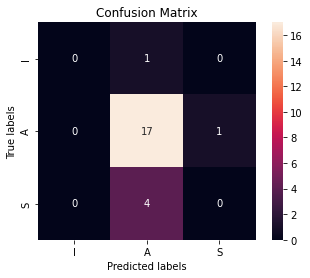

In [ ]:
# get the heatmap of confusion matrix
labels = ['I' , 'A' , 'S']
ax= plt.subplot()
sns.heatmap(cm,square = True,annot = True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

From above confusion matrix, we can conclude that among the test data, predicted 17 labels correctly as A, while 1 as A which was actually I and 4 were actual S.

**Decisioon Tree**

In [ ]:
# Decision tree model
classf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=8, random_state=0)
classf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=8, random_state=0)

In [ ]:
y_predicted = classf.predict(X_test)

In [ ]:
accuracy_score(y_predicted , y_test)

0.7391304347826086

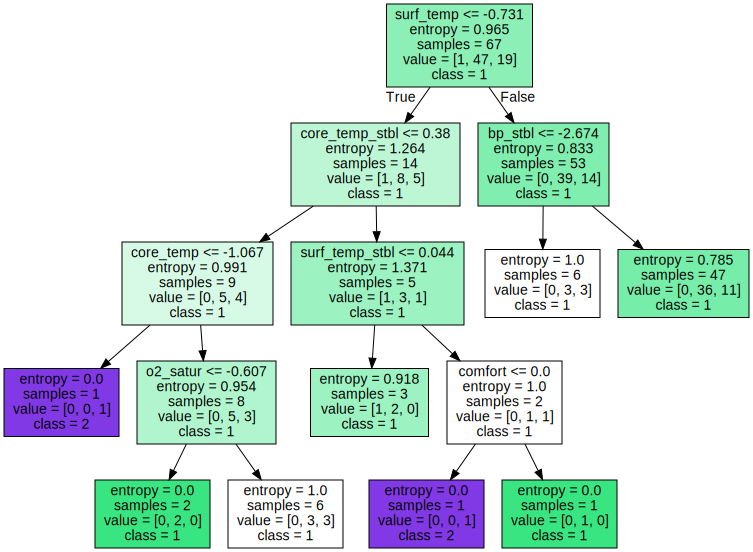

In [ ]:
graph = Source(tree.export_graphviz(classf, out_file=None
   , feature_names=independent_variables, class_names=['0', '1' , '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

**k Nearest Nearest Neighbor**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 13)
 
knn.fit(X_train, y_train)
pred = knn.predict(X_test)


In [ ]:
accuracy_score(pred , y_test)

0.8695652173913043

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, pred))
 
print(classification_report(y_test, pred))

[[19  0]
 [ 3  1]]
              precision    recall  f1-score   support

           1       0.86      1.00      0.93        19
           2       1.00      0.25      0.40         4

    accuracy                           0.87        23
   macro avg       0.93      0.62      0.66        23
weighted avg       0.89      0.87      0.84        23



The accuracy rate of the test data is 86.95% 

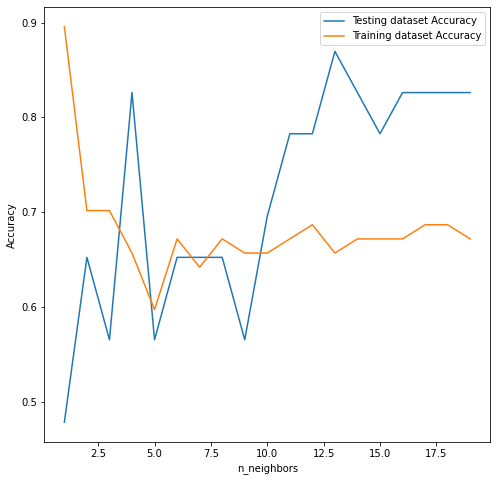

In [ ]:
# checking for which k does the accuracy of the model is highest
neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
        
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

For k = 13 our model has the highest accuracy

##**Conclusion**

That's it! We reached the end of our exercise.
Starting with loading the data so far, we have done EDA, null values treatment, encoding of categorical columns, feature selection and then model building.
In first two models that is Logistic regression model and Decision Tress, our accuracy revolves in the range of 70 to 74%. While for the k-NN model the accuracy is 86.95%.
So, the accuracy of our best model is 87% which can be said to be good for this dataset. This performance could be due to various reasons like: no proper pattern of data, not enough relevant features.
